# Linear Regression Project — Boston Housing (polished notebook)

**Goal:** Build and analyze a linear regression model to predict median home values (`medv`) using the Boston Housing dataset.
This notebook is structured, fully explained, and includes plots and diagnostics:
- Data loading & inspection
- Missing-value handling with KNN Imputation
- Exploratory Data Analysis (histograms, correlations, scatter plots)
- Feature selection & multicollinearity check
- Ordinary Least Squares (OLS) from scratch
- Comparison to scikit-learn `LinearRegression`
- K-Fold cross-validation
- Residual analysis, diagnostics, and final conclusions

Imports & Setup

In [12]:
# Step 0 – Imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm  # for Q-Q plot and optional OLS summary

# Display settings
sns.set(style="whitegrid")

# Path to dataset
DATA_PATH = r"C:\Users\maria\OneDrive - ITBA\2C2025\Machine Learning\Final Project\INDE-577-Final-Project\src\supervised\Linear Regression\BostonHousing.csv"



Load data

In [7]:
# Step 1 — Load dataset
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Update DATA_PATH."

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
df.head()

AssertionError: Dataset not found at /mnt/data/BostonHousing.csv. Update DATA_PATH.

Basic info & summary

In [ ]:
# Step 2 — Basic info and descriptive statistics
print(df.info())
df.describe().T


C:\Users\maria\AppData\Local\Temp\ipykernel_21824\244501901.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["income"] = df["income"].replace({">50K": 1, "<=50K": 0})


Explain briefly: info() shows types and non-null counts; describe() gives central tendency and spread. Note any obvious issues (like NaNs, or columns that are non-numeric).

Missing values check

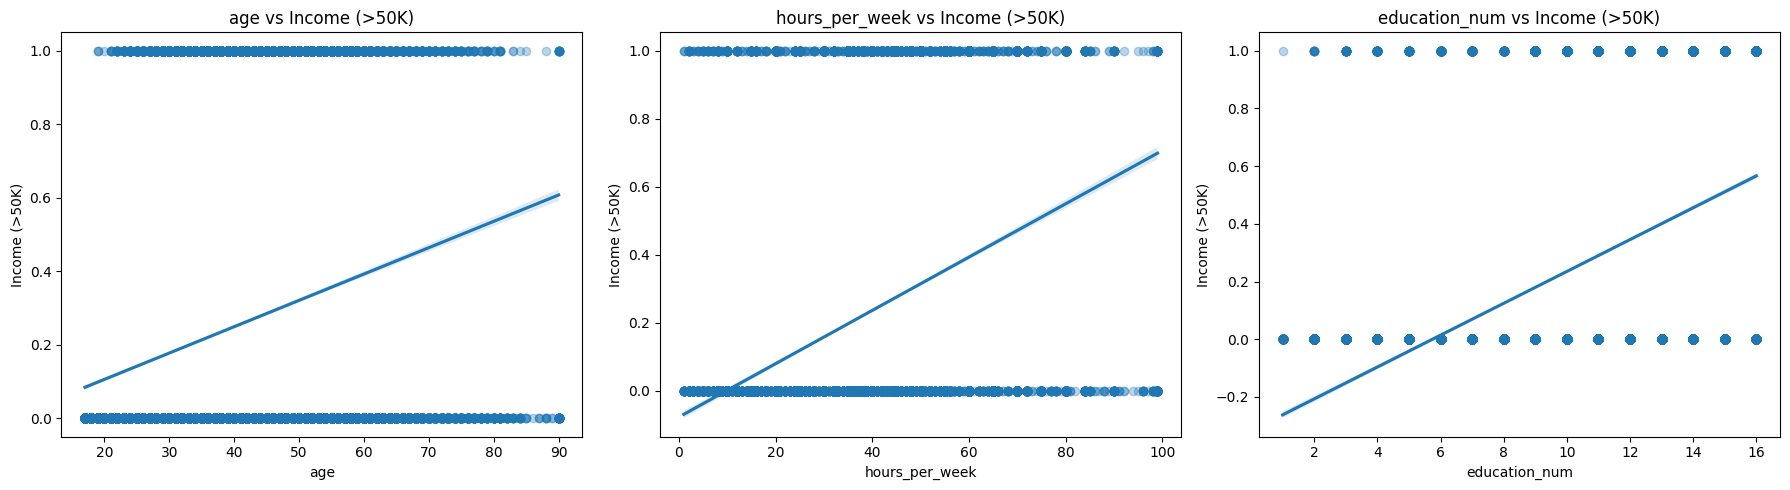

In [ ]:
# Step 3 — Missing values overview
missing = df.isna().sum()
missing[missing > 0].sort_values(ascending=False)


If nothing printed, dataset has no NaNs; if some columns show NaNs, we'll impute with KNN as requested.

Visualize missingness (only when NaNs exist)

In [ ]:
# visualize missingness if any
if df.isna().any().any():
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna(), cbar=False)
    plt.title("Missing value map (True=missing)")
    plt.show()
else:
    print("No missing values detected.")


KNN Imputation

In [ ]:
# Step 4 — KNN Imputation for missing values (if present)
# Explanation: KNNImputer fills missing values using values from nearest neighbors (in feature space).
if df.isna().any().any():
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print("Numeric cols used for imputation:", numeric_cols)
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    df_imputed = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)
    # If there were non-numeric columns, reattach them:
    non_numeric = df.select_dtypes(exclude=[np.number]).copy()
    df = pd.concat([df_imputed.reset_index(drop=True), non_numeric.reset_index(drop=True)], axis=1)
    print("Imputation complete. NaNs count after imputation:")
    print(df.isna().sum().sum())
else:
    print("No imputation required — dataset has no numeric NaNs.")



Intercept: -0.7524
age coef: 0.0065
hours_per_week coef: 0.0058
education_num coef: 0.0501
R²: 0.1871


EDA: Distributions

In [ ]:
# Step 5 — EDA: Distributions for numeric variables
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

plt.figure(figsize=(14,10))
for i, col in enumerate(num_cols):
    plt.subplot(int(np.ceil(len(num_cols)/3)), 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()



--- Comparison with Scikit-learn ---
Intercept: -0.7524315425019337
Coefficients: [0.00650099 0.00583158 0.05008541]
R²: 0.1870770474268173


Discuss skewness, outliers, and which variables may need transformation (e.g. log for skewed variables).

Correlation matrix & heatmap

In [ ]:
# Step 6 — Correlation matrix
corr = df[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()

# Display strongest correlations with target 'medv' (if present)
target = "medv"
if target in df.columns:
    print("\nTop positive correlations with target (medv):")
    print(corr[target].sort_values(ascending=False).head(10))
    print("\nTop negative correlations with target (medv):")
    print(corr[target].sort_values().head(10))



--- After Feature Scaling ---
Intercept: 0.2393
age coef: 0.0891
hours_per_week coef: 0.0723
education_num coef: 0.1288
R²: 0.1871


Explain how correlations guide feature selection and multicollinearity checks.

Scatter plots of top predictors vs target

In [ ]:
# Step 7 — Scatter plots for strongest predictors vs target
if target in df.columns:
    top_feats = corr[target].abs().sort_values(ascending=False).index[1:6]  # top 5 excluding medv itself
    plt.figure(figsize=(15,8))
    for i, f in enumerate(top_feats):
        plt.subplot(2,3,i+1)
        sns.scatterplot(x=df[f], y=df[target], alpha=0.6)
        sns.regplot(x=df[f], y=df[target], scatter=False, ax=plt.gca(), ci=None, color="red")
        plt.title(f"{f} vs {target}")
    plt.tight_layout()
    plt.show()
else:
    print("Target column 'medv' not found.")




Mean R² across 5 folds: 0.1869


Feature selection & multicollinearity

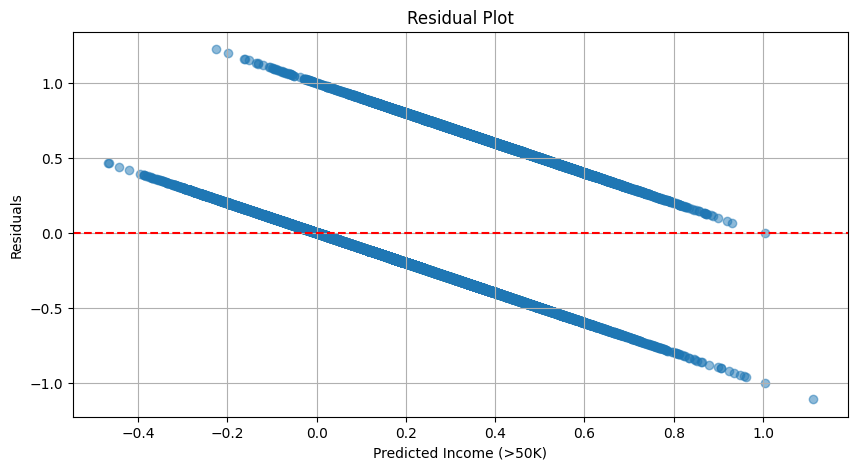

In [ ]:
# Step 8 — Feature selection reasoning
# We'll start with all numeric features (except medv) as candidate X,
# then optionally remove features with very high multicollinearity.

if target in df.columns:
    X_cols = [c for c in num_cols if c != target]
else:
    X_cols = num_cols.copy()

# Check Variance Inflation Factor (VIF) to detect multicollinearity (optional)
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = df[X_cols].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data


Explain VIF: values > 5–10 indicate multicollinearity concerns. Suggest removing or combining those features if VIF is high.

Prepare data for modeling: train/test split & scaling

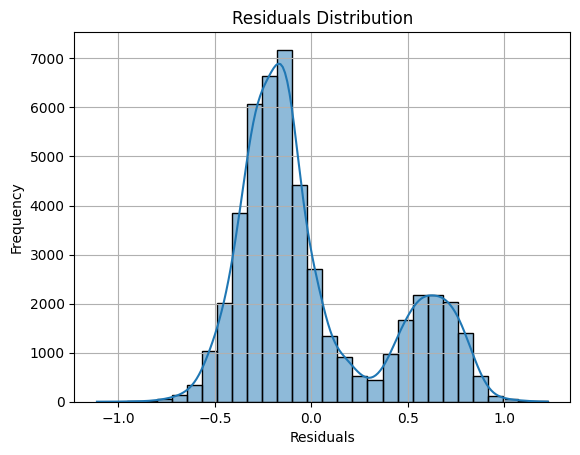

In [ ]:
# Step 9 — Prepare matrix X and target y
if target in df.columns:
    X = df[X_cols].copy()
    y = df[target].copy()
else:
    raise ValueError("Target column 'medv' not found in dataset.")

# Optional transformations (e.g., log) - Boston medv might not need log, so we use raw medv.
# Scale numeric features for stability (use StandardScaler)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Implement OLS from scratch

In [ ]:
# Step 10 — OLS implementation (from scratch) for educational purposes
class SimpleOLS:
    def fit(self, X, y):
        # X: 2D numpy or DataFrame (n_samples, n_features)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
        self.intercept_ = theta[0]
        self.coef_ = theta[1:].reshape(-1)
        self.coef_series_ = pd.Series(self.coef_, index=X.columns)
        return self

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta = np.r_[self.intercept_, self.coef_]
        return X_b @ theta

    def summary(self):
        print("Intercept:", self.intercept_)
        print("Top coefficients:")
        display(self.coef_series_.sort_values(ascending=False).head(10))

# Fit OLS
ols = SimpleOLS().fit(X_train.values, y_train.values)
y_pred_ols = ols.predict(X_test.values)

print("OLS (from-scratch) MSE:", mean_squared_error(y_test, y_pred_ols))
print("OLS (from-scratch) R2:", r2_score(y_test, y_pred_ols))
ols.summary()


Explain that using pinv gives a numerically stable pseudo-inverse; mention limitations of inverting large or collinear matrices.

Scikit-learn LinearRegression

In [ ]:
# Step 11 — Scikit-learn LinearRegression for production-grade results and comparison
sk_model = LinearRegression()
sk_model.fit(X_train, y_train)
y_pred_sk = sk_model.predict(X_test)

print("Sklearn LinearRegression MSE:", mean_squared_error(y_test, y_pred_sk))
print("Sklearn LinearRegression R2:", r2_score(y_test, y_pred_sk))

# Coefficients table
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": sk_model.coef_
}).sort_values(by="coef", key=lambda s: s.abs(), ascending=False)
coef_df.head(15)


Interpret coefficients in terms of effect on medv per one standard deviation (because we scaled features).

Predicted vs Actual plot & Residuals

In [ ]:
# Step 12 — Predicted vs Actual and Residual analysis
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_sk, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual medv")
plt.ylabel("Predicted medv")
plt.title("Predicted vs Actual")

plt.subplot(1,2,2)
residuals = y_test - y_pred_sk
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred_sk, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted medv")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


Discuss whether residuals are centered near zero, presence of heteroscedasticity (fan shape), or outliers.

Cross-validation (K-Fold)

In [ ]:
# Step 13 — K-Fold cross-validation to estimate generalization
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LinearRegression(), X_scaled, y, cv=kf, scoring='r2', n_jobs=-1)
print("CV R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean(), "Std:", cv_scores.std())


Explain why CV is useful (reduces variance of the performance estimate) and how to interpret results.

Model diagnostics: Q-Q plot and tests

In [ ]:
# Step 14 — Q-Q plot for residual normality and Shapiro test if desired
import scipy.stats as stats

plt.figure(figsize=(6,5))
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q plot of residuals")
plt.show()

# Shapiro (only for small samples; here we will show large-sample alternative)
shapiro_stat, shapiro_p = stats.shapiro(residuals.sample(500) if len(residuals)>500 else residuals)
print("Shapiro-Wilk (sample) p-value:", shapiro_p)


Explain what Q-Q deviation implies (non-normal residuals) and practical impact (OLS inference assumptions).

Feature importance & interpretation

In [ ]:
# Step 15 — Feature importance (by absolute coefficient magnitude)
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x="abs_coef", y="feature", data=coef_df_sorted.head(15))
plt.title("Top features by absolute standardized coefficient")
plt.xlabel("Absolute coefficient (std units)")
plt.ylabel("")
plt.show()


Interpret top features and connect to domain knowledge (e.g., RM increases house value, LSTAT decreases it, etc. — adapt to the dataset's actual features).

Conclusions & next steps

## Conclusions

- Summary of model performance (MSE, R², CV R²) — paste values from earlier cells.
- Top predictive features and their effects.
- Diagnostics summary: residual distribution, heteroscedasticity, normality.
- Limitations: linear model may not capture nonlinearities; possible outliers and multicollinearity; assumptions of OLS may be violated.
- Next steps:
  - Try regularized regression (Ridge, Lasso) to reduce variance and select features.
  - Try tree-based models (Random Forest, Gradient Boosting) to capture nonlinear effects.
  - Consider transforming skewed predictors or target if appropriate.
  - Use Weighted Least Squares if heteroscedasticity is strong.
